In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline

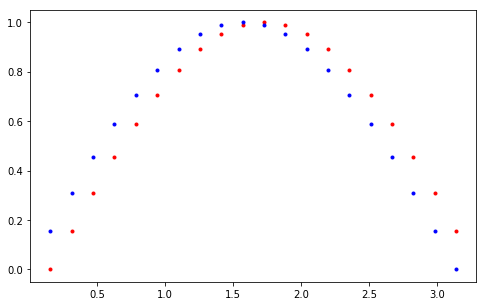

In [5]:
pyplot.figure(figsize=(8, 5))

# number of data points in one batch of data
seq_length = 20

#generate the data - f(x) = sin(x)
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length + 1, 1), adds an input_size dimension

x = data[:-1] # all the points, with exception of the last
y = data[1:] # all the points, with exception of the first

# The red is the color is x values, x = sin(x) 
# and the blue is the color of the y = sin(x+1)
pyplot.plot(time_steps[1:], x, 'r.', label='input x')
pyplot.plot(time_steps[1:], y, 'b.', label='target y')

# Defining the RNN

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
    
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first = True)
        # last layer, a fully-conected
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        # get rnn outputs
        r_out, hidden = self.rnn(x, hidden)
        # get final output from fully-conected
        output = self.fc(r_out)
        return output, hidden

In [17]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)
# generate the test ata
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0)
print('Input size: {}'.format(test_input.size()))

# testing the output from rnn
test_out, test_h = test_rnn(test_input, None)
print('Output size: {}'.format(test_out.size()))
# the first number is the number of layers, the second is the batch size and the last is hidden_dim
print('Hidden state size: {}'.format(test_h.size()))      

Input size: torch.Size([1, 20, 1])
Output size: torch.Size([1, 20, 1])
Hidden state size: torch.Size([2, 1, 10])


# Training the RNN

In [30]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

rnn = RNN(input_size, output_size, hidden_dim, n_layers)

## Loss and Optimzation

In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

## Train Function

In [24]:
def train(rnn, n_steps, print_every):
    hidden = None
    
    for batch_i, step in enumerate(range(n_steps)):
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # size becomes (seq_length + 1, 1), adds an input_size dimension

        x = data[:-1] # all the points, with exception of the last
        y = data[1:] # all the points, with exception of the first
        
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        prediction, hidden = rnn(x_tensor, hidden)
        # to don't propagate  the entire history
        hidden = hidden.data
        
        loss = criterion(prediction, y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_i % print_every == 0:
            print("Loss: {}".format(loss.item()))
            pyplot.plot(time_steps[1:], x, 'r.')
            pyplot.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.')
            pyplot.show()
            
    return rnn

Loss: 0.763771653175


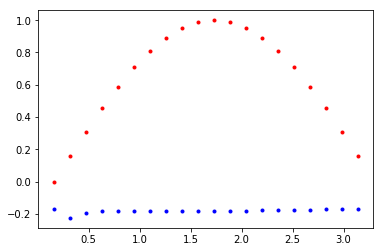

Loss: 0.284393996


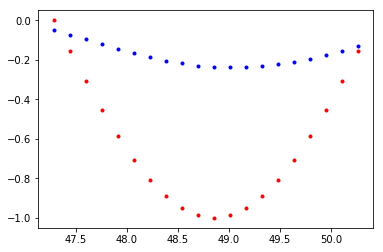

Loss: 0.160057201982


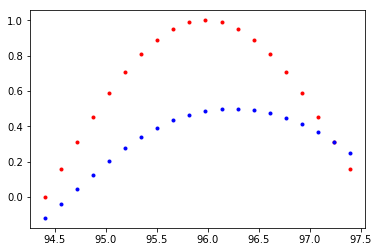

Loss: 0.0736629739404


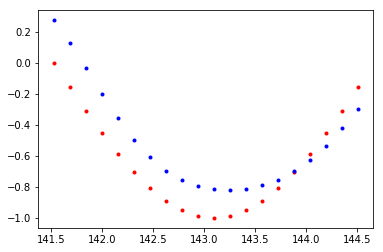

Loss: 0.0217226371169


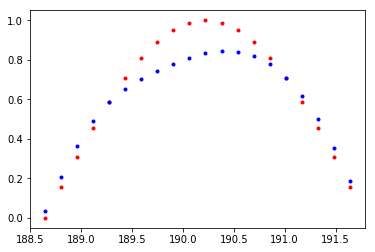

Loss: 0.017400579527


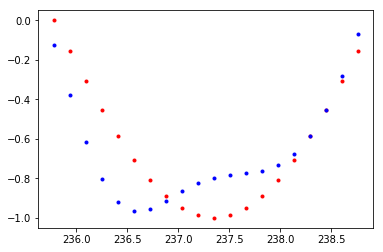

Loss: 0.00912829581648


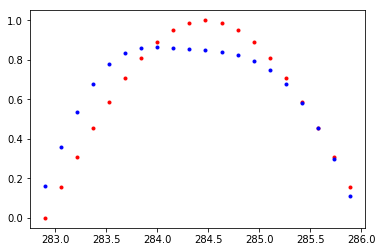

In [32]:
n_steps = 105
print_every = 15
trainded_rnn = train(rnn, n_steps, print_every)